In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt 
from fastai.tabular import *
from fastai.callbacks import ReduceLROnPlateauCallback,EarlyStoppingCallback
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
import os
print(os.listdir("../input"))

Using TensorFlow backend.


['sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
class roc(Callback):
    
    def on_epoch_begin(self, **kwargs):
        self.total = 0
        self.batch_count = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = F.softmax(last_output, dim=1)
        roc_score = roc_auc_score(to_np(last_target), to_np(preds[:,1]))
        self.total += roc_score
        self.batch_count += 1
    
    def on_epoch_end(self, num_batch, **kwargs):
        self.metric = self.total/self.batch_count

## Load Data

In [3]:
train = pd.read_csv("../input/train.csv").drop('ID_code',axis=1)
test = pd.read_csv("../input/test.csv")

In [4]:
sm = SMOTE(random_state = 21)
x_res, y_res = sm.fit_resample(train.iloc[:,1:], train['target'])

In [5]:
dep_var = 'target'
cont_names = train.iloc[:,1:].columns.tolist()

In [6]:
train_res = pd.DataFrame(data = x_res,columns = cont_names)
train_res['target'] = y_res

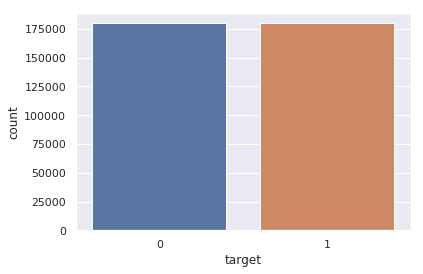

In [7]:
sns.set(style="darkgrid")
ax =  sns.countplot(x="target", data=train_res)

In [8]:
procs = [Normalize]

In [9]:
test = TabularList.from_df(test,cont_names=cont_names)

In [10]:
data = (TabularList.from_df(train_res,cont_names=cont_names, procs=procs)
                           .random_split_by_pct(0.15)
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch(bs=32))

In [11]:
learn = tabular_learner(data, 
                        layers=[200,100], 
                        metrics=[accuracy,roc()]
                       )

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-03


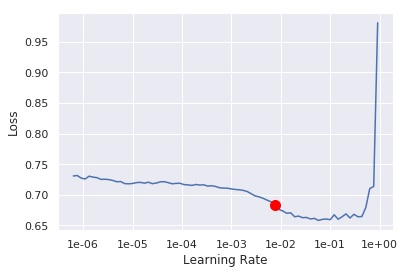

In [13]:
learn.recorder.plot()

In [14]:
##ES = EarlyStoppingCallback(learn, monitor='roc',patience = 5)
##RLR = ReduceLROnPlateauCallback(learn, monitor='roc',patience = 2)

In [15]:
learn.fit(1, .01,)

epoch,train_loss,valid_loss,accuracy,roc
1,0.371210,0.318869,0.870762,0.943035


In [16]:
preds,_ = learn.get_preds(DatasetType.Test)

In [17]:
preds = preds.tolist()

In [18]:
preds_nn = []
for i in range(len(preds)):
    preds_nn.append(preds[i][0])

In [19]:
subby = pd.read_csv("../input/test.csv")
subby['target'] = preds_nn


In [20]:
subby = subby[['ID_code','target']]

In [21]:
subby.to_csv('subby.csv',index=False)

In [22]:
subby.head()

,ID_code,target
0,test_0,0.649870
1,test_1,0.389245
2,test_2,0.871294
3,test_3,0.721385
4,test_4,0.496783
